In [34]:
import os,sys
import h5py
import shutil
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
from tqdm import tqdm
from PIL import Image
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize



## Let's discover the different labels 

In [35]:
import os

rootdir = os.getcwd()
datadir = os.path.join( rootdir, 'Desktop\\10.1yolov3\\augmenting')
#path, dirs, files = next(os.walk(datadir))

list_dir = []
list_dir = os.listdir(datadir)
print(list_dir)

class_size = [0]*len(list_dir)

count = 0
for name in list_dir:
    dir_name = os.path.join(datadir, name)
    onlyfiles = next(os.walk(dir_name))[2] #dir is your directory path as string
    class_size[count] = len(onlyfiles) 
    count +=1
                 
print(class_size)


['axjp', 'pred_SR', 'temp', 'train_SR', 'valid_SR', 'xmlxml']
[371, 0, 0, 0, 0, 0]


## Let's see the distribution of each class in the dataset

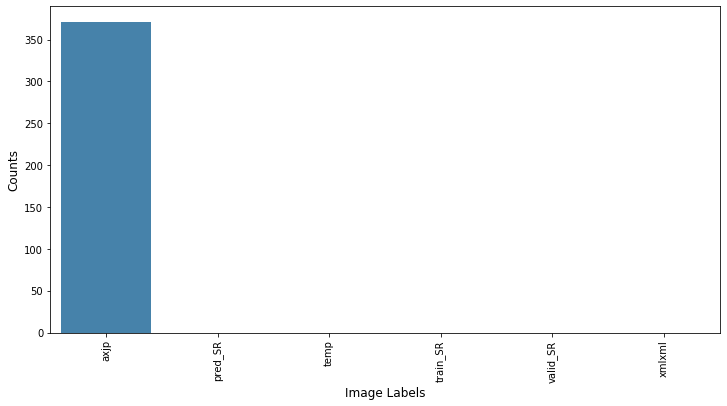

In [36]:
plt.figure(figsize = (12,6))
sns.barplot( list_dir,class_size, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Put each training image into a sub folder corresponding to its label after converting to JPG format


## Some agile data augmentation (to prevent overfitting) + class balance


In [37]:
 # Define functions for contrast adjustment


# Contrast stretching
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq                  

In [38]:
datagen = ImageDataGenerator(
        rotation_range=1,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        fill_mode='nearest',
        preprocessing_function =contrast_stretching )

datagen2 = ImageDataGenerator(
        rotation_range=1,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        fill_mode='nearest',
        preprocessing_function =HE )

datagen3 = ImageDataGenerator(
        rotation_range=1,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        fill_mode='nearest',
        preprocessing_function =AHE )

avg_class_size=2000

src_train_dir=os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting')
dest_train_dir=os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting\\train_SR')
dest_valid_dir=os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting\\valid_SR')
dest_predict_dir=os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting\\pred_SR')
dest_temp_dir = os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting\\temp')
src_xml_dir = os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting\\xmlxml\\xml')
dest_xml_dir = os.path.join(rootdir,'Desktop\\10.1yolov3\\augmenting\\xmlxml\\xml_New')

it=0

for count in class_size:
    #nb of generations per image for this class label in order to make it size ~= class_size
    ratio=math.floor(avg_class_size/count)-1
    print(count, ratio, count*(ratio+1))
    dest_lab_dir=os.path.join(dest_train_dir,list_dir[it])
    src_lab_dir=os.path.join(src_train_dir,list_dir[it])
    dest_val_dir=os.path.join(dest_valid_dir,list_dir[it])
    dest_pred_dir=os.path.join(dest_predict_dir,list_dir[it])
    dest_temp_dir = os.path.join(dest_temp_dir)
    
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
        os.makedirs(dest_val_dir)
        os.makedirs(dest_pred_dir)
        print(dest_pred_dir)
    num =0
    for file in os.listdir(src_lab_dir):
        img=load_img(os.path.join(src_lab_dir,file))
        if (num ==3 or num ==7):
            img.save(os.path.join(dest_val_dir,file))
        elif (num == 9):
            img.save(os.path.join(dest_pred_dir,file))   
        else:
            img.save(os.path.join(dest_lab_dir,file))   
        num = num+1
        if (num==10):
            num=0
        if ratio >0:
            x=img_to_array(img) 
            x=x.reshape((1,) + x.shape)
            i=0
            if(num==1 or num==5):
                for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg'):
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    datagen2.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file,  save_format='jpg')
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    datagen3.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg')
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    
            elif (num == 9):
                for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg'):
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    datagen2.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg')
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    datagen3.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg')
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
            else:
                for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg'):
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    datagen2.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg')
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 
                    datagen3.flow(x, batch_size=1,save_to_dir=dest_temp_dir, save_prefix=file, save_format='jpg')
                    for temp in os.listdir(dest_temp_dir):
                        print(temp.split('.jpg')[0])
                        name = temp.split('.jpg')[0]
                        shutil.move(dest_temp_dir +'/' + temp, dest_train_dir + '/' +temp)
                        for xml in os.listdir(src_xml_dir):
                            if xml.rstrip('.xml') == name:
                                shutil.copy(src_xml_dir +'/' + xml, dest_train_dir + '/' +temp.rstrip('.jpg') + '.xml')
                    i+=1
                    if i > ratio:
                        break 

            
                        

    it=it+1

371 4 1855
C:\Users\steve\Desktop\10.1yolov3\augmenting\pred_SR\axjp
1578190580651drqq5w6url21
1578190580651drqq5w6url21
1578190631285i0o11wqixlxc
1578190631285i0o11wqixlxc
15782809523351f0hvk7wts
15782809523351f0hvk7wts
1578280980660emlo283vcnn
1578280980660emlo283vcnn
15783644880212dyvzh79ar
15783644880212dyvzh79ar
15784015421538cycls33usmq
15784015421538cycls33usmq
1578543054184qyt170hhtam
1578543054184qyt170hhtam
157865026744628lrxx849
157865026744628lrxx849
1578792511448v8v2mhkclu
1578792511448v8v2mhkclu
1578792535262khqw5my5am3h
1578792535262khqw5my5am3h
1578893627719rb1kh8n1wb
1578893627719rb1kh8n1wb
1579237757602i0yc8zoeacd
1579237757602i0yc8zoeacd
1579312669809ykmwww3n7wl
1579312669809ykmwww3n7wl
15793165523109yohdazxxrq
15793165523109yohdazxxrq
1579322163309i8bmz3y6ih2s
1579322163309i8bmz3y6ih2s
1579491942805z19k0is4hi
1579491942805z19k0is4hi
1579610270684wh11rslkhlm
1579610270684wh11rslkhlm
1579610279884smwzhv0uu9q
1579610279884smwzhv0uu9q
1579610318906lniekot7wze8
157961031

1583306957767xvu5rq7c0mq3
1583318079885ttv5ihb1umu
1583318079885ttv5ihb1umu
1583318208259nevz4r7zk4z
1583318208259nevz4r7zk4z
15833182637841i87ut705dz3
15833182637841i87ut705dz3
1583319227055om8x8r59q3
1583319227055om8x8r59q3
15833192395834aqos67s1nm
15833192395834aqos67s1nm
1583319263468nf9yyedbb1aa
1583319263468nf9yyedbb1aa
158331927047600e9ex0w2xhq
158331927047600e9ex0w2xhq
15833595963347omwd3vcs336
15833595963347omwd3vcs336
1583365093024yuyva0tea7
1583365093024yuyva0tea7
15833651075194o21ek702m
15833651075194o21ek702m
1583381438320qb30z6z165h
1583381438320qb30z6z165h
15833852437656albmx4f6no9
15833852437656albmx4f6no9
1583387056386115kqk8uouf
1583387056386115kqk8uouf
1583401331129107bn5uu2x88
1583401331129107bn5uu2x88
15834028803864dbm7icqihf
15834028803864dbm7icqihf
1583422720648hqowwzqrv9xl
1583422720648hqowwzqrv9xl
1583447634893tno6oike4
1583447634893tno6oike4
15834550510113nm1ib4vfq
15834550510113nm1ib4vfq
1583480547000v5bmvmm55qu
1583480547000v5bmvmm55qu
15834835774181hrdqqr0e

1585566729262z83zxma421yz
1585572817503t27lh5eiotq
1585572817503t27lh5eiotq
1585583392680mzm5q26b4vx
1585583392680mzm5q26b4vx
1585583409735av8lrw4ic1d
1585583409735av8lrw4ic1d
1585614421644kkzz9wx9nya
1585614421644kkzz9wx9nya
15856148204731ydyi6qovewv
15856148204731ydyi6qovewv
1585633252612h2vaocx9w53
1585633252612h2vaocx9w53
1585646705296n38h5zdcys7
1585646705296n38h5zdcys7
158569217235195lk2eazq6s
158569217235195lk2eazq6s
1585696299840803evrnnmue0
1585696299840803evrnnmue0
15857176874088n9bu1q1ytdl
15857176874088n9bu1q1ytdl
1585719968970oyfr5441xul
1585719968970oyfr5441xul
1585725015028mlo4c8714we
1585725015028mlo4c8714we
1585740860560bia7vh4lad7x
1585740860560bia7vh4lad7x
1585814449083qielr3idfl
1585814449083qielr3idfl
1585821406251amvf73z269
1585821406251amvf73z269
1585867524530qvnx45hb3ow
1585867524530qvnx45hb3ow
15858680125188eb1zr1xv7
15858680125188eb1zr1xv7
1585879770580heomsml4fl
1585879770580heomsml4fl
1585890808679r58birhtu40
1585890808679r58birhtu40
1585895768067eb0162fy0mr

ZeroDivisionError: division by zero

## Let's check the new distribution

In [ ]:
 for dirpath, dirnames, filenames in os.walk(dest_train_dir):
    i=0
    label=''
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        label=os.path.split(dirpath)[1]
        i+=1
    print(label,i)
        